In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/btchistoricaldata/BTC-Time-Series.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import codecs
import csv
import sys


<h2>This will be by far one of the most comprehensive Notebooks on Time Series Analysis 
with Tensorflow <br> </h2>
This is the course that I have followed 
<a href="https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery"> TF Course </a>


<h3> Time Series has an added concept of time which makes the data dynamic.<br> 
Majorly this notebook is focused on Forecasting Data. <br>
The idea is to build a multi-variate Model and to forecast results with Prediction Intervals.


<h3>Window is the amount of data that is given to the Model.<br>
The future for which we want to predict the Value is called the horizon. <br>
Also there can be various sequence to sequence Problems with different mappings like
One to One, Many to One, One to Many, Many to Many etc.

In [3]:
df=pd.read_csv("../input/btchistoricaldata/BTC-Time-Series.csv",parse_dates=['Date'],index_col=['Date'])
df.head()
# Parse Dates indicates that it is a datetime column

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


<h4> The various types of Time Series 
<ul>
  <li>Trend - Can be Increasing or Decreasing, Linear, Curved etc.</li>
  <li>Seasonal Patterns - Differs on Datetime and changes by Months, days etc.</li>
  <li>Cyclic - Increases and Decreases but not periodically or on fixed times like Seasonals</li>
</ul>
Also there are univariate and Multi-variate Time Series Data.
<ul>
    <li> Univariate - Using a parameter to Predict the same parameter</li>
    <li> Multi-variate- Using Multiple Time dependent params or dependecies to Predict one parameter </li>
</ul>
</h4>

In [5]:
# Coin Desk also has Data available for some Cryptocurrencies via an API
btc_price=pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
btc_price.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


<h3> EDA

Text(0, 0.5, 'BTC Price')

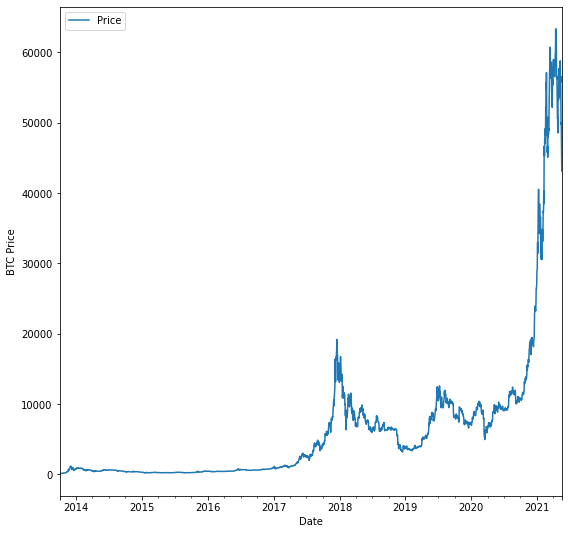

In [6]:
# Getting the Trend Curve for the Prices
btc_price.plot(figsize=(9,9))
plt.ylabel("BTC Price")

<h3>
    An alternative way to read the Data with Python's CSV Function
   

In [7]:
import csv
from datetime import datetime
timesteps=[]
btc_prices=[]
with open("../input/btchistoricaldata/BTC-Time-Series.csv","r") as f:
    csv_reader=csv.reader(f,delimiter=",")
    next(csv_reader)
    # Iterator and Lines 
    for line in csv_reader:
        # Get the Dates
        timesteps.append(datetime.strptime(line[1],'%Y-%m-%d'))
        # Get the Closing Prices
        btc_prices.append(float(line[2]))
timesteps[:10],btc_prices[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

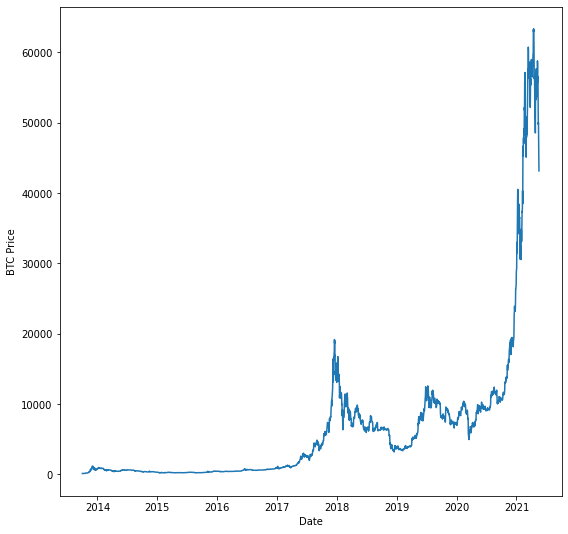

In [8]:
plt.figure(figsize=(9,9))
plt.plot(timesteps,btc_prices)
plt.ylabel("BTC Price")
plt.xlabel("Date")


<h4>The Time Data cannot be split Randomly. It has to be splitted in the Order of time.<br>
    Otherwise it will cause a Data leak issue<br>
    So we have to create a pseudo Future Data as a turnaround for this

In [9]:
# Creating Train Test Split for Time Series Data 
timesteps=btc_price.index.to_numpy()
prices=btc_price["Price"].to_numpy()

In [10]:
# 80% Training Data and 20% Testing Data
split_size=int(0.8*len(prices))

# Create an Internal Train Data Split 
X_train,y_train=timesteps[:split_size],prices[:split_size]
# Creating test data Splits (beyond the Split)
X_test,y_test=timesteps[split_size:],prices[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)


(2229, 2229, 558, 558)

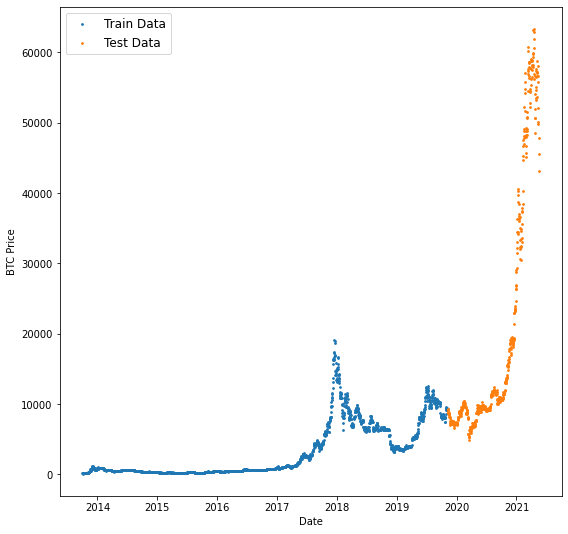

In [11]:
# Plotting the Training and Testing Data
plt.figure(figsize=(9,9))
plt.scatter(X_train,y_train,label="Train Data",s=3)
plt.scatter(X_test,y_test,label="Test Data",s=3)
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=12)
plt.show()

In [12]:
# Modularity for creating a Plotting function
def plot_series(timesteps,values,format=".",start=0,end=None,label=None):
#     plt.figure(figsize=(9,9))
    # Plot the Series
    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Date")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=12)
    plt.grid(True)
  
    

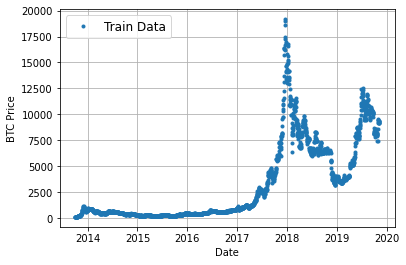

In [13]:
# Plotting the Train
plot_series(timesteps=X_train,values=y_train,label="Train Data")

<h2> There will be Multiple Models trained in this Notebook <h2>
   <h4> <ul>
       <li>Naive Bayes Model</li>
       <li>Dense Model </li>
       <li> Dense Model with some Tweaks and Hyperparameters Tuning and changing Horizons and Windows</li>
       <li>Conv 1D</li>
       <li> LSTM - Long short term Memory</li>
       <li>Dense Model by Introducing Multivariate Data</li>
       <li>N-BEATS Algorithm</li>
       <li> Ensembling or Stacking the aforementioned Models </li>
       <li> Future Prediction Model</li>
       </ul>
    </h4>
 Note:
    <h3>* <b>Horizon</b> --> The Number of Values that are going to be predicted in the Future<br>
        * <b>Window Size </b> --> The input size that is given to the Model to Predict the future.

<h3> Naive Model <h3>

In [14]:
# Making a Naive Forecasting Model
# Offsetting the y_test by 1
naive_forecast=y_test[:-1]
naive_forecast[:10],naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

<h4> So basically what we are doing is that we are Predicting the Previous Steps' value as the value of the Next Step in the Naive's Model

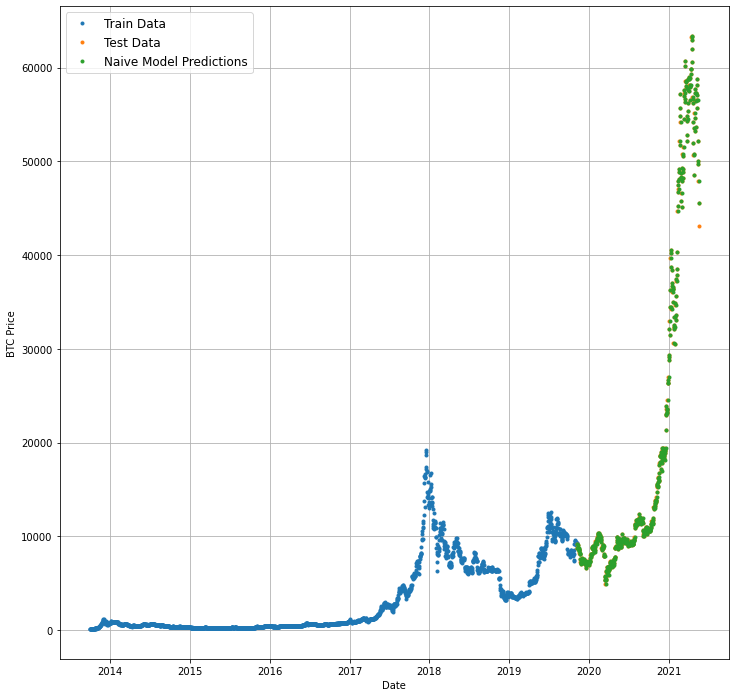

In [15]:
plt.figure(figsize=(12,12))
plot_series(timesteps=X_train,values=y_train,label="Train Data")
plot_series(timesteps=X_test,values=y_test,label="Test Data")
plot_series(timesteps=X_test[1:],values=naive_forecast,label="Naive Model Predictions")

#  They can be offseted and Formatted in different terms

<h3>Metrics for Evaluating the Time Series Forecasting </h3> 
<ul>
 MAE <br>
 MSE <br>
 Huber Loss <br>
 RMS <br>
 sMAPE <br>
 MASE <br>
 </ul>

In [16]:
# Implementing MASE mean absolute scaled error as  there is not built in functionality in TF
# No seasonality Version
import tensorflow as tf
def MASE(y_true,y_pred):
    mae=tf.reduce_mean(tf.abs(y_true-y_pred))
    mae_naive_noseason=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
    # The seasonality is one Day in this case of no seasonality
    return mae/mae_naive_noseason

In [17]:
MASE(y_true=y_test[1:],y_pred=naive_forecast).numpy()



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

0.9995699939182626

In [18]:
# Creating a Super-set Function for evaluating the Prediction on all the given Metrics
def evaluate_prediction(y_true,y_pred):
        # For Evaluation Metrics we need a Float 32 .
        y_true=tf.cast(y_true,dtype=tf.float32)
        y_pred=tf.cast(y_pred,dtype=tf.float32)
        mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
        mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
        # Root Mean Squared
        rmse=tf.sqrt(mse)
        smape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
        mase=MASE(y_true,y_pred)
        # Return them into a dictionary Type
        return {"mae":mae.numpy(),
               "mse":mse.numpy(),
               "rmse":rmse.numpy(),
               "smape":smape.numpy(),
               "mase":mase.numpy()}


In [19]:
# Naive Results
naive_model_results=evaluate_prediction(y_true=y_test[1:],y_pred=naive_forecast)
naive_model_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'smape': 2.516525,
 'mase': 0.99957}

<h3>Windowing our Data <br>
To make the Problem a Supervised Learning Problem <br>
So for each Set of 7 values we Predict for the 8th Value<br>
</h3>

In [20]:
HORIZON=1
WINDOW=7


In [21]:
def get_window_label(x,horizon=HORIZON):
    return x[:,:-horizon], x[:,-horizon]
    

In [22]:
test_window, test_label=get_window_label(tf.expand_dims(tf.range(8)+1,axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([8], dtype=int32)>)

<h4>
Here we have leveraged Numpy's Array Indexing Methods <br>
Create a 2D Array of Windows one after the other as 1-D Arrays in the space.<br>
Then use the 2D Array of Multiple windows to index on a Target Series.

In [23]:
# IMP 
# Sliding window Approach
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):

  # Turns a 1D array into a 2D array of sequential windows of window_size.
 
  # Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  # create 2D array of windows of size window_size
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
  # Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # Get the labelled windows
  windows, labels = get_window_label(windowed_array, horizon=horizon)

  return windows, labels

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)


(2780, 2780)

In [25]:
# Although there is an inbuilt function
# tf.keras.preprocessing.timeseries_dataset_from_array


<h3> Now we will Split these windows into Training set and Test Set </h3>

In [26]:
def train_test_splits(windows,labels,test_split=0.2):
    #Here we will not randomize this Process and Ensure the same Window-Label pairs are together in the same set at the same place
    split_size=int(len(windows)*(1-test_split)) # 80 % 1-t_s
    train_windows=windows[:split_size]
    train_labels=labels[:split_size]
    test_windows=windows[split_size:]
    test_labels=labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels
    

In [27]:
train_windows,test_windows,train_labels, test_labels=train_test_splits(full_windows,full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [28]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW:])

True

<h2> Creating a Modelling Checkpoint  Callback <h2> <h4>So we want the Models best performance at whichever epoch it has and then save it. <br>
    This facilitates us to compare the best performing versions of each of the Model that we write <br>
    So we will save the best Only
    

In [29]:
import os
os.mkdir("/kaggle/working/model_checkpoints1")

In [30]:
def create_model_checkpoint(model_name, save_path="./model_checkpoints"):
  # create filepath to save model
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, 
                                            save_best_only=True) 
# only output a limited amount of text and Save Only the best Model to the File

<h2> Dense Model <h2>

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
tf.random.set_seed(42)
# Creating the Model
model_1=tf.keras.Sequential([layers.Dense(128,activation="relu"),
                           layers.Dense(HORIZON,activation="linear")],name="model_1_Dense")
# Compiling the Model
model_1.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae","mse"])

# Fitting the Model
model_1.fit(x=train_windows,y=train_labels,epochs=100,verbose=1,batch_size=128,validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

2022-01-06 15:22:06.118058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 780.3469 - mae: 780.3469 - mse: 2312739.0000 - val_loss: 2279.5833 - val_mae: 2279.5833 - val_mse: 12772098.0000


2022-01-06 15:22:07.275121: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 247.6765 - mae: 247.6765 - mse: 285480.9688 - val_loss: 1005.9865 - val_mae: 1005.9865 - val_mse: 3441760.2500
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 188.4107 - mae: 188.4107 - mse: 171890.0469 - val_loss: 923.2859 - val_mae: 923.2859 - val_mse: 2868195.7500
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 169.4334 - mae: 169.4334 - mse: 151699.4375 - val_loss: 900.5931 - val_mae: 900.5931 - val_mse: 2683714.2500
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 165.0899 - mae: 165.0899 - mse: 145490.8594 - val_loss: 895.2404 - val_mae: 895.2404 - val_mse: 2564605.7500
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 158.5206 - mae: 158.5206 - mse: 133816.7812 - val_loss: 855.1867 - val_mae: 855.1867 - val_mse: 2481815.2500
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 151.3568 - mae:

In [32]:
# Evaluating the Model in the Test Data
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 662.5306 - mae: 662.5306 - mse: 1358188.1250


[662.5305786132812, 662.5305786132812, 1358188.125]

In [33]:
# The best performance is in the Callbacks and we can Load that
model_1=tf.keras.models.load_model("./model_checkpoints/model_1_Dense")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 568.5499 - mae: 568.5499 - mse: 1172588.1250


[568.5498657226562, 568.5498657226562, 1172588.125]

<h3> Function for making the Forecasts

In [34]:
def make_forecast(model,input_data):
    forecast = model.predict(input_data)
    # return 1D array of predictions
    return tf.squeeze(forecast) 
    

In [35]:
model_1_preds = make_forecast(model_1, test_windows)
len(model_1_preds)

556

In [36]:
#  Evaluating the Model
# Evaluate preds
model_1_results = evaluate_prediction(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.5499,
 'mse': 1172588.1,
 'rmse': 1082.8611,
 'smape': 2.5492296,
 'mase': 0.9987847}

In [37]:
test_labels.shape,model_1_preds.shape

((556,), TensorShape([556]))

In [38]:
offset = 300
plt.figure(figsize=(9, 9))
# Account for the test_window offset and index into test_labels to ensure correct plotting
# Fix This
# plot_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# plot_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

<h2> Dense Model with Changes in the Window = 30 and HORIZON =1 

In [39]:
HORIZON = 1 # predict one step at a time
WINDOW = 30 # use 30 timesteps in the past

In [40]:

full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [41]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

<h3> Dense Model but with different size of WINDOW </h3>

In [42]:
import tensorflow as tf
from tensorflow.keras import layers

In [43]:
model_2=tf.keras.Sequential([layers.Dense(128,activation="relu"),layers.Dense(1,activation="linear")],name="model_2_Dense")
model_2.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae","mse"])
model_2.fit(x=train_windows,y=train_labels,epochs=100, verbose=0,batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [44]:
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 628.4876 - mae: 628.4876 - mse: 1308524.5000


[628.4876098632812, 628.4876098632812, 1308524.5]

In [45]:
# Load in best performing model
model_2 = tf.keras.models.load_model("./model_checkpoints/model_2_Dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 605.8220 - mae: 605.8220 - mse: 1256325.0000


[605.822021484375, 605.822021484375, 1256325.0]

In [46]:
# Get forecast predictions
model_2_preds = make_forecast(model_2,input_data=test_windows)
# model_2_preds

In [47]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_prediction(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.822,
 'mse': 1256324.9,
 'rmse': 1120.859,
 'smape': 2.738649,
 'mase': 1.0589827}

<h2> Model with Window Size of 30 and Horizon size =7 </h2>

In [48]:
HORIZON = 7
WINDOW=30

In [49]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [50]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [51]:
tf.random.set_seed(42)
model_3=tf.keras.Sequential([layers.Dense(128,activation="relu"),layers.Dense(HORIZON)],name="model_3_Dense")
model_3.compile(loss="mae",optimizer=tf.keras.optimizers.Adam(),metrics=["mae","mse"])
model_3.fit(x=train_windows,y=train_labels,epochs=100, verbose=0,batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [52]:
# Loading the best version of the Model
model_3 = tf.keras.models.load_model("./model_checkpoints/model_3_Dense")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 598.0229 - mae: 598.0229 - mse: 1225796.1250


[598.0228881835938, 598.0228881835938, 1225796.125]

In [53]:
model_3_preds = make_forecast(model_3,
                           input_data=test_windows)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9129.693, 9222.32 , 9244.148, 9278.311, 9297.15 , 9355.404,
        9246.305],
       [8807.845, 8914.247, 8967.434, 8879.294, 8840.167, 8894.859,
        8907.916],
       [8810.007, 8778.099, 8843.638, 8784.469, 8710.661, 8737.325,
        8769.325],
       [8981.532, 8810.691, 8798.775, 8905.492, 8734.211, 8856.119,
        8793.93 ],
       [8870.186, 8724.783, 8599.239, 8774.379, 8817.4  , 8852.64 ,
        8701.279]], dtype=float32)>

In [54]:
test_labels.shape,model_3_preds.shape

((551,), TensorShape([551, 7]))

In [55]:
# You'll notice the outputs for model_3_results are multi-dimensional.

# This is because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

# To fix this, let's adjust our evaluate_preds() function to work with multiple shapes of data.

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = MASE(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

<h2> Conv 1D Model

In [56]:
import tensorflow as tf
from tensorflow.keras import layers


In [57]:
HORIZON=1
WINDOW=7

In [58]:
# We have to reinstatiate it every time
full_windows, full_labels = make_windows(prices, window_size=WINDOW, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [59]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

The Conv1D layer in TensorFlow takes an input of: (batch_size, timesteps, input_dim):<br>
timesteps = WINDOW
input_dim = HORIZON 


In [60]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )
# So now we need to expand our dim

(7,)

In [61]:
# SO we need to reshape the data to pass it through the Conv1D Layer
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [62]:
#  Adding an extra Dimension to x
#  So we are turning a Lambda Function to a Keras model passable Layer 
expand_dims_layer=layers.Lambda(lambda x: tf.expand_dims(x,axis=1))


In [63]:
#  Building the Model
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [64]:
model_4 = tf.keras.models.load_model("./model_checkpoints/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 1ms/step - loss: 569.0329


569.0328979492188

In [65]:
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 8847.292 ,  8757.502 ,  8997.469 ,  8762.801 ,  8707.722 ,
        8713.594 ,  8664.934 ,  8496.83  ,  8439.472 ,  8499.395 ,
        8242.241 ,  8095.7085,  8046.407 ,  7673.703 ,  7288.221 ,
        7261.61  ,  7074.771 ,  7152.6074,  7119.7305,  7436.9375,
        7421.823 ,  7676.419 ,  7596.6543,  7417.1807,  7321.3374,
        7302.1484,  7212.8223,  7334.977 ,  7481.6953,  7535.0537,
        7545.111 ,  7367.607 ,  7239.5786,  7180.912 ,  7170.7734,
        7204.6724,  7090.6084,  7082.624 ,  6902.465 ,  6613.245 ,
        7236.9805,  7222.117 ,  7145.396 ,  7229.8794,  7271.6562,
        7194.9805,  7195.5835,  7212.704 ,  7181.7476,  7200.7803,
        7289.0537,  7374.642 ,  7272.3843,  7176.505 ,  7156.878 ,
        6978.427 ,  7202.794 ,  7323.581 ,  7353.2515,  7647.5996,
        8022.178 ,  8126.659 ,  7877.2734,  8041.413 ,  8110.6807,
        8154.175 ,  8110.42  ,  8632.221 ,  8882.792 ,  8776.874 ,
        8894.9

In [66]:
# Evaluate results for model 4 predictions
model_4_results = evaluate_prediction(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.0329,
 'mse': 1169841.5,
 'rmse': 1081.5922,
 'smape': 2.551526,
 'mase': 0.9996332}